## Pairs Trading

In [1]:
#!pip install pandas
#!pip install yfinance
#!pip install datapackage
#!pip install bs4
#!pip install requests
#!pip install pykalman

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

Retrieving list of S&P 500 tickers

In [4]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-2]
        tickers.append(ticker)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

sp_tickers = save_sp500_tickers()
#sp_tickers

### Data Extraction

We use daily close data from yfinance for all tickers in the S&P500 index

In [5]:
def extract_data(ticker_list):
    return yf.download(ticker_list)["Close"]

df = extract_data(list(sp_tickers))
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  380 of 380 completed

82 Failed downloads:
- XE: 1d data not available for startTime=-2208988800 and endTime=1658075483. Only 100 years worth of day granularity data are allowed to be fetched per request.
- : No data found for this date range, symbol may be delisted
- BF.: No data found, symbol may be delisted
- SN: No data found, symbol may be delisted
- LM: No data found, symbol may be delisted
- FI: No data found, symbol may be delisted
- N: 1d data not available for startTime=-2208988800 and endTime=1658075484. Only 100 years worth of day granularity data are allowed to be fetched per request.
- IV: 1d data not available for startTime=-2208988800 and endTime=1658075485. Only 100 years worth of day granularity data are allowed to be fetched per request.
- ZIO: 1d data not available for startTime=-2208988800 and endTime=1658075485. Only 100 years worth of day granularity data are allowed to be fetched per request.
- MM: 1d data not 

In [6]:
df.tail()

,,AA,AAP,AB,ABB,ABM,AC,AD,ADB,ADS,...,WYN,XE,XO,XRA,XY,YU,ZB,ZBR,ZIO,ZT
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-11,NaN,42.730000,181.750000,41.020000,26.440001,43.209999,37.680000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.72
2022-07-12,NaN,42.250000,183.839996,41.009998,26.420000,42.750000,36.860001,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13,NaN,43.189999,185.339996,40.779999,26.590000,42.540001,36.759998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.71
2022-07-14,NaN,40.810001,186.009995,40.430000,26.330000,42.160000,37.169998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.72
2022-07-15,NaN,43.060001,188.710007,41.029999,26.930000,42.560001,37.900002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Train Test Split

Define the period for training data and test data

In [7]:
train_start_date = pd.to_datetime("2016-01-01")
train_end_date = pd.to_datetime("2020-12-31")
  
test_start_date = pd.to_datetime("2021-01-01")
test_end_date = pd.to_datetime("2021-12-31")

Note: After defining the training period and test period, we drop the stocks which have missing data in either periods.

Some of the stocks may not have been listed in the period and may have been delisted. We can ignore them from our universe.

In [8]:
df_train = df[((df.index > train_start_date) & (df.index < train_end_date))]

# First delete rows that have missing values
df_train.dropna(how='all', axis=0, inplace=True) 

# Delete columns that have any missing value
df_train.dropna(how='any', axis=1, inplace=True)

df_train.head()

,AA,AAP,AB,ABB,ABM,AC,AE,AL,ALG,ALL,...,TSC,TX,TY,V,VT,VTR,W,WB,WD,WM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,23.333130,152.240005,23.639999,17.520000,27.670000,29.313433,38.230000,32.830002,50.959999,60.669998,...,13.65,12.16,19.740000,75.699997,56.650002,56.740002,44.189999,18.860001,28.530001,52.450001
2016-01-05,22.275810,151.199997,23.100000,17.209999,27.570000,29.950249,39.290001,32.849998,52.130001,60.529999,...,13.27,11.96,19.830000,76.269997,56.660000,57.740002,43.459999,19.270000,28.770000,52.650002
2016-01-06,20.689831,147.199997,22.969999,16.920000,27.299999,29.860697,39.060001,31.980000,51.119999,59.849998,...,13.32,11.71,19.620001,75.269997,55.820000,57.209999,42.959999,18.940001,28.950001,53.299999
2016-01-07,19.872810,148.830002,22.450001,16.600000,26.719999,29.582090,38.150002,29.910000,50.099998,58.439999,...,13.02,11.31,19.250000,73.790001,54.520000,56.209999,41.500000,17.049999,27.370001,52.669998
2016-01-08,19.392210,145.559998,21.830000,16.309999,26.580000,29.542290,38.720001,28.500000,49.810001,58.230000,...,12.72,11.01,19.070000,72.879997,53.880001,56.259998,42.150002,17.420000,27.670000,52.349998


In [9]:
df_test = df[((df.index > test_start_date) & (df.index < test_end_date))]

# First delete rows that have missing values
df_test.dropna(how='all', axis=0, inplace=True) 

# Delete columns that have any missing value
df_test.dropna(how='any', axis=1, inplace=True)

df_test.head()

,AA,AAP,AB,ABB,ABM,AC,AE,AI,AL,ALG,...,V,VRT,VT,VTR,W,WB,WD,WF,WH,WM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,23.250000,157.339996,33.250000,28.270000,36.919998,34.959999,23.879999,120.010002,42.389999,137.740005,...,217.759995,18.52,92.050003,46.880001,236.460007,40.660000,87.290001,26.469999,58.389999,114.830002
2021-01-05,23.670000,157.169998,33.189999,28.920000,38.189999,34.450001,23.660000,122.169998,43.740002,140.440002,...,214.509995,18.15,93.059998,47.439999,241.929993,41.090000,88.860001,26.370001,59.150002,115.209999
2021-01-06,25.209999,166.250000,34.340000,29.670000,41.110001,33.779999,23.450001,113.400002,44.360001,150.850006,...,212.619995,18.25,93.720001,48.369999,241.880005,41.340000,93.320000,26.870001,61.910000,117.760002
2021-01-07,25.230000,167.669998,34.970001,30.040001,41.130001,35.840000,23.520000,133.580002,43.720001,149.429993,...,213.809998,18.27,94.669998,47.439999,250.070007,41.990002,89.809998,27.600000,61.169998,118.050003
2021-01-08,24.990000,170.059998,34.889999,30.260000,40.750000,36.490002,23.570000,143.630005,43.320000,144.570007,...,215.449997,18.07,95.529999,47.139999,258.380005,43.380001,88.720001,27.559999,60.849998,118.599998


We take the common set of stocks from train and test set and drop the rest of the data

In [10]:
c = np.intersect1d(df_train.columns,df_test.columns)

In [11]:
df_train = df_train[c]
df_train.head()

,AA,AAP,AB,ABB,ABM,AC,AE,AL,ALG,ALL,...,TSC,TX,TY,V,VT,VTR,W,WB,WD,WM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,23.333130,152.240005,23.639999,17.520000,27.670000,29.313433,38.230000,32.830002,50.959999,60.669998,...,13.65,12.16,19.740000,75.699997,56.650002,56.740002,44.189999,18.860001,28.530001,52.450001
2016-01-05,22.275810,151.199997,23.100000,17.209999,27.570000,29.950249,39.290001,32.849998,52.130001,60.529999,...,13.27,11.96,19.830000,76.269997,56.660000,57.740002,43.459999,19.270000,28.770000,52.650002
2016-01-06,20.689831,147.199997,22.969999,16.920000,27.299999,29.860697,39.060001,31.980000,51.119999,59.849998,...,13.32,11.71,19.620001,75.269997,55.820000,57.209999,42.959999,18.940001,28.950001,53.299999
2016-01-07,19.872810,148.830002,22.450001,16.600000,26.719999,29.582090,38.150002,29.910000,50.099998,58.439999,...,13.02,11.31,19.250000,73.790001,54.520000,56.209999,41.500000,17.049999,27.370001,52.669998
2016-01-08,19.392210,145.559998,21.830000,16.309999,26.580000,29.542290,38.720001,28.500000,49.810001,58.230000,...,12.72,11.01,19.070000,72.879997,53.880001,56.259998,42.150002,17.420000,27.670000,52.349998


In [12]:
df_test = df_test[c]
df_test.head()

,AA,AAP,AB,ABB,ABM,AC,AE,AL,ALG,ALL,...,TSC,TX,TY,V,VT,VTR,W,WB,WD,WM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,23.250000,157.339996,33.250000,28.270000,36.919998,34.959999,23.879999,42.389999,137.740005,108.080002,...,17.260000,29.389999,29.090000,217.759995,92.050003,46.880001,236.460007,40.660000,87.290001,114.830002
2021-01-05,23.670000,157.169998,33.189999,28.920000,38.189999,34.450001,23.660000,43.740002,140.440002,107.230003,...,17.940001,31.059999,29.180000,214.509995,93.059998,47.439999,241.929993,41.090000,88.860001,115.209999
2021-01-06,25.209999,166.250000,34.340000,29.670000,41.110001,33.779999,23.450001,44.360001,150.850006,109.989998,...,19.670000,32.580002,29.549999,212.619995,93.720001,48.369999,241.880005,41.340000,93.320000,117.760002
2021-01-07,25.230000,167.669998,34.970001,30.040001,41.130001,35.840000,23.520000,43.720001,149.429993,110.070000,...,19.450001,33.139999,29.920000,213.809998,94.669998,47.439999,250.070007,41.990002,89.809998,118.050003
2021-01-08,24.990000,170.059998,34.889999,30.260000,40.750000,36.490002,23.570000,43.320000,144.570007,109.949997,...,19.370001,32.610001,30.209999,215.449997,95.529999,47.139999,258.380005,43.380001,88.720001,118.599998


We define a list of stocks among which we wish to find cointegrated pairs.
Ideally one can carry out the operation for entire list of stocks in the training data set. But this is a computationally heavy task and hence we encourage the user to define a smaller list of stocks of interest to find cointegrated pairs.

In [13]:
import random

stock_list = random.sample(list(c),10)

### Calculating Cointegration Coefficient for pairs of stocks

#### Cointegration

If (X,Y,Z) are each [integrated](https://en.wikipedia.org/wiki/Order_of_integration) of order d, and there exist coefficients a,b,c such that aX + bY + cZ is integrated of order less than d, then X, Y, and Z are cointegrated.

Let's begin by calculating cointergration coefficient between JP Morgan and Goldman Sachs

#### Engle-Granger Two-Step Method

Null Hypothesis $H_{0}$: No co-integration exists between $x$ & $y$

In [14]:
from statsmodels.tsa.stattools import coint

def engle_granger_test(x,y):
  
    # coint() returns the t-stat, p-value & critical values 
    # for 1%, 5% and 10% levels of significance
    eg = coint(x,y)

    # t-statistic
    t_stat = eg[0]

    # p-value for t-statistic at 5% LOS
    p_val = eg[1]

    # if p-value is less than x% LOS (5 in this case)
    # we reject the Null-Hypothesis
    if p_val < 0.05:
        if t_stat<eg[2][1]:
          # Cointegration exists
          return [p_val, "Co-integrated"]
    else:
        # Cointegration does not exist
        return [p_val, "Not Co-integrated"]

In [15]:
coint_res = {}
n = len(stock_list)
for i in range(n):
    for j in range(i+1,n):
        a = stock_list[i]
        b = stock_list[j]
        resk = a + ", " + b
        resv = engle_granger_test(df_train[a],df_train[b])
        coint_res[resk] = resv

In [16]:
df_coint = pd.DataFrame(list(coint_res.values()), 
                        columns =["p-value","Co-integration"], 
                        index=coint_res.keys())

df_coint = df_coint[df_coint["Co-integration"]=='Co-integrated']
df_coint

,p-value,Co-integration
"ALG, WD",0.031724,Co-integrated
"D, HP",0.021981,Co-integrated
"KE, GNR",0.033487,Co-integrated
"FR, HP",0.002475,Co-integrated


Out of our series of co-integrated stocks, we choose the first pair for our analysis.

In [17]:
coint_pair = df_coint.index[0].split(", ")
coint_pair

['ALG', 'WD']

### Kalman Filtering

Now that we have identified a co-integrated pair, we use Kalman filtering to develop the hedge ratio for creating a pairs trade. 

The kalman_filtering function returns the state's means (slope) and covariances (intercept). 

The slope in this output is our hedge ratio for the co-integrated stocks.

In [18]:
from pykalman import KalmanFilter

def kalman_filtering(pair):
   
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [df_train[pair[0]].values, np.ones(df_train[pair[0]].values.shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(df_train[pair[1]].values)
    return state_means, state_covs

Hedge Ratio = $\frac{coint\_pair[1]}{coint\_pair[0]}$



$coint\_pair[1] = \beta \hspace{0.1cm} (coint\_pair[0]) + \epsilon$

In [19]:
state_means, state_covs = kalman_filtering(coint_pair)

In [20]:
df_trade = df_train[coint_pair].copy(deep=True)
df_trade["Slope"] = state_means[:,0]
df_trade["Intercept"] = state_means[:,1]
#df_trade["Kalman Estimate"] =

df_trade.head()

,ALG,WD,Slope,Intercept
Date,,,,
2016-01-04,50.959999,28.530001,0.548873,0.548873
2016-01-05,52.130001,28.770000,0.545057,0.545154
2016-01-06,51.119999,28.950001,0.548635,0.548468
2016-01-07,50.099998,27.370001,0.545211,0.545519
2016-01-08,49.810001,27.670000,0.545069,0.545407


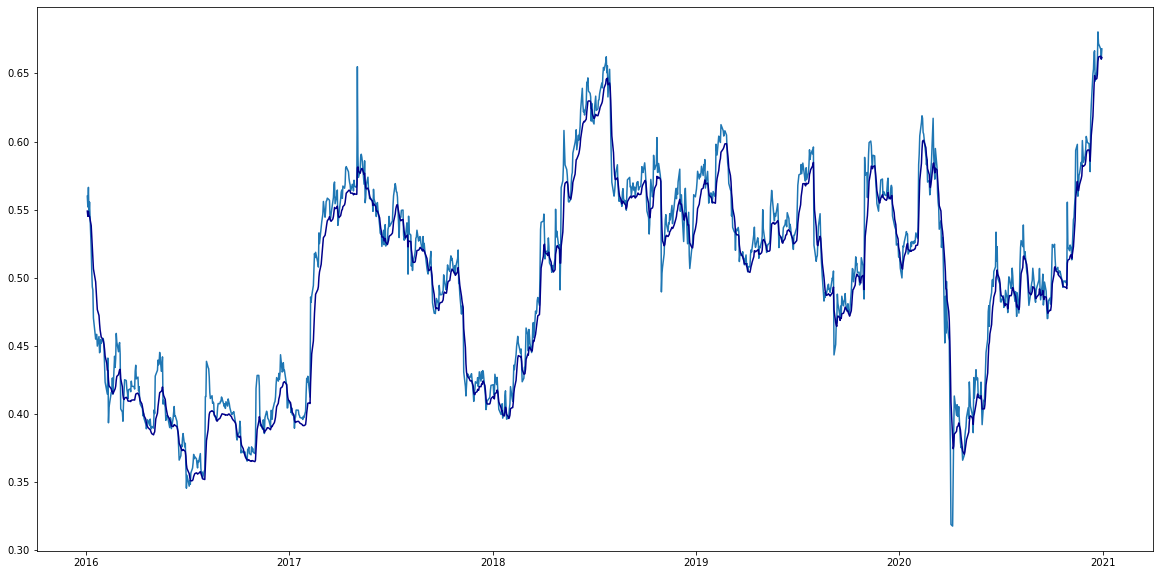

In [22]:
plt.figure(figsize=(20,10))
plt.plot(df_trade.iloc[:,1]/df_trade.iloc[:,0])
plt.plot(df_train.index, df_trade["Slope"], color="#00008B")

Text(0.5, 1.0, 'HEDGE RATIO')

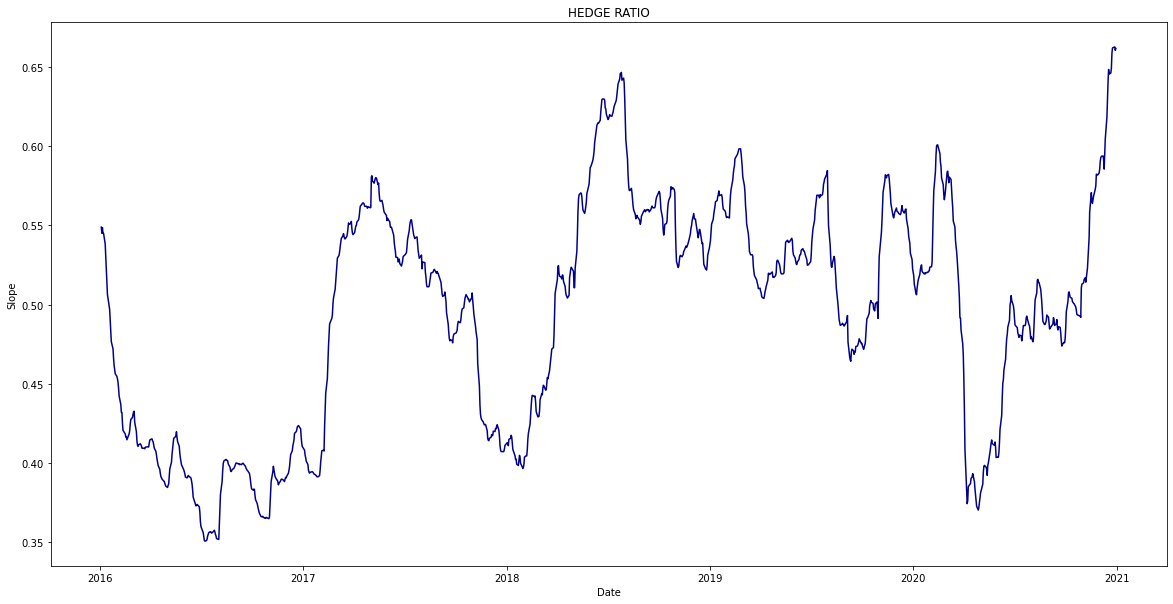

In [23]:
plt.figure(figsize=(20,10))
plt.plot(df_train.index, df_trade["Slope"], color="#00008B")
plt.xlabel("Date")
plt.ylabel("Slope")
plt.title("HEDGE RATIO")

Text(0.5, 1.0, 'INTERCEPT')

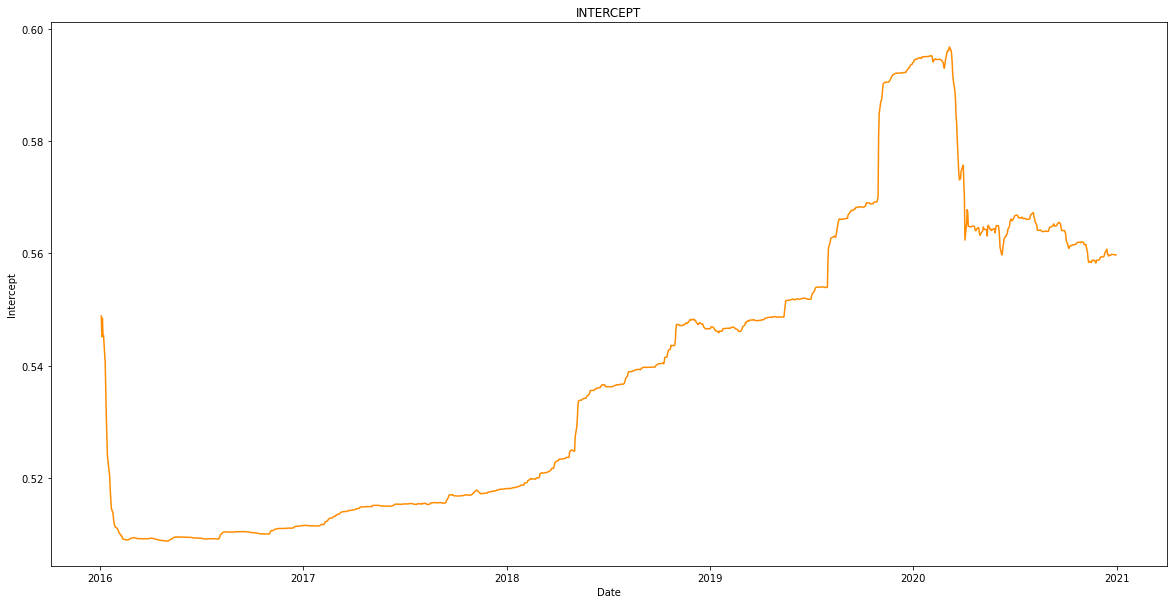

In [24]:
plt.figure(figsize=(20,10))
plt.plot(df_train.index, df_trade["Intercept"], color="#ff8c00")
plt.xlabel("Date")
plt.ylabel("Intercept")
plt.title("INTERCEPT")

The next step would be to check if the time series of the hedge ratio, i.e. state_means is mean reverting or not.

This can be done using the Hurst Exponent test.

If it is, then we find its long run mean about which it will keep reverting. 
If not, then we assume that the simple moving average or 

In [ ]:
"""
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print("Hurst(GBM):   %s" % hurst(gbm))
print("Hurst(MR):    %s" % hurst(mr))
print("Hurst(TR):    %s" % hurst(tr))

# Assuming you have run the above code to obtain 'goog'!
print("Hurst(GOOG):  %s" % hurst(goog['Adj Close'].values))
"""

In [25]:
def trading_bounds(trading_data, window_length, SD_multiple):
    
    # X-day SMA of hedge ratio
    trading_data["Slope_SMA"] = trading_data["Slope"].rolling(window=window_length).mean()
    
    # S.D. bounds for the hedge ratio
    trading_data["Upper_Bound"] = trading_data["Slope_SMA"] + \
                                  SD_multiple*trading_data["Slope"].rolling(window=window_length).std()
    
    trading_data["Lower_Bound"] = trading_data["Slope_SMA"] - \
                                  SD_multiple*trading_data["Slope"].rolling(window=window_length).std()
    
    return trading_data

In [26]:
df_trade = trading_bounds(trading_data = df_trade, 
                          window_length = 20, 
                          SD_multiple = 2)

df_trade.tail()

,ALG,WD,Slope,Intercept,Slope_SMA,Upper_Bound,Lower_Bound
Date,,,,,,,
2020-12-23,137.660004,93.680000,0.658910,0.559826,0.610872,0.666426,0.555317
2020-12-24,137.830002,92.620003,0.662081,0.559818,0.614859,0.673168,0.556551
2020-12-28,138.880005,92.750000,0.662695,0.559803,0.618906,0.678757,0.559056
2020-12-29,136.380005,90.089996,0.660546,0.559705,0.622783,0.682888,0.562678
2020-12-30,136.220001,91.000000,0.661718,0.559747,0.626587,0.686422,0.566752


### References

Kalman Filtering - https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/

In [27]:
df_trade = df_trade.dropna()

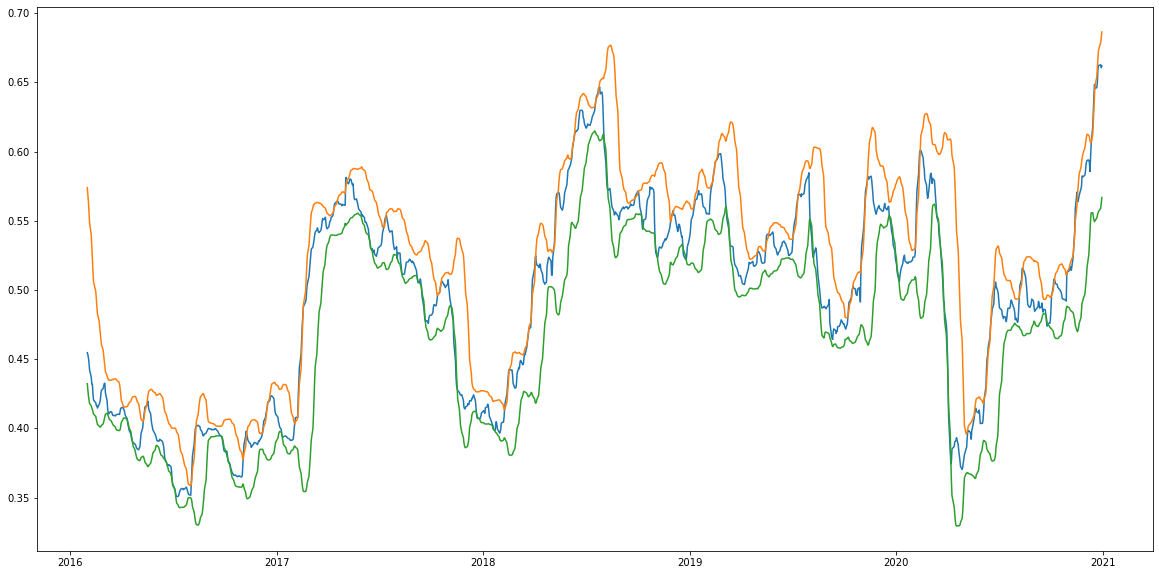

In [28]:
plt.figure(figsize=(20,10))
plt.plot(df_trade["Slope"])
plt.plot(df_trade["Upper_Bound"])
plt.plot(df_trade["Lower_Bound"])

In [29]:
def trading_strategy(data, lower_bb, upper_bb, S1, S2):
    buy_price = []
    sell_price = []
    bb_signal = [0] * len(data)
    countS1 = 0
    countS2 = 0
    money = 0
    flag  = 0
    for i in range(len(data)):
        # BUY the Hedge Ratio, i.e. 
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            flag = 1
            bb_signal[i] = flag
            money -= S1[i] - S2[i] * data[i]
            countS1 += 1
            countS2 -= data[i]
            flag = 0
        
        # SELL the Hedge Ratio, i.e. 
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            flag = -1
            bb_signal[i] = flag
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            flag = 0
    
    return money, pd.Series(bb_signal,index = data.index)

In [31]:
trading_strategy(data = df_trade["Slope"], 
                 lower_bb = df_trade["Lower_Bound"], 
                 upper_bb = df_trade['Upper_Bound'], 
                 S1 = df_trade.iloc[:,1], 
                 S2 = df_trade.iloc[:,0])

(45.005543283289406,
 Date
 2016-02-01    0
 2016-02-02    0
 2016-02-03    0
 2016-02-04    0
 2016-02-05    0
              ..
 2020-12-23    0
 2020-12-24    0
 2020-12-28    0
 2020-12-29    0
 2020-12-30    0
 Length: 1239, dtype: int64)

In [56]:
def trading_strategy(ratios, s1, s2, UBand, LBand):
    
    s1_buy_prices = []
    s1_sell_prices = []
    
    s2_buy_prices = []
    s2_sell_prices = []
    
    capital = 0
    
    # Hedge ratio = s1 / s2
     
    for i in range(len(ratios)):
        
        # BUY the hedge ratio
        # BUY S1 and SELL S2
        if ratios[i] < LBand[i] and ratios[i-1] > LBand[i-1]:
            s1_buy_prices.append([df_trade.index[i], s1[i]])
            s2_sell_prices.append([df_trade.index[i], s2[i]])
            capital -= s1[i] - ratios[i]*s2[i]    
            
        # SELL the hedge ratio
        # SELL S1 and BUY S2
        elif ratios[i] > UBand[i] and ratios[i-1] < UBand[i-1]:
            s1_sell_prices.append([df_trade.index[i], s1[i]])
            s2_buy_prices.append([df_trade.index[i], s2[i]])
            capital += s1[i] - ratios[i]*s2[i]
            
    s1_buy_action = pd.DataFrame(s1_buy_prices, columns = ["Date","Price"]).set_index("Date")
    s1_sell_action = pd.DataFrame(s1_sell_prices, columns = ["Date","Price"]).set_index("Date")
    s2_buy_action = pd.DataFrame(s2_buy_prices, columns = ["Date","Price"]).set_index("Date")
    s2_sell_action = pd.DataFrame(s2_sell_prices, columns = ["Date","Price"]).set_index("Date")
            
    return capital, s1_buy_action, s1_sell_action, s2_buy_action, s2_sell_action 
    #return capital, s1_buy_prices, s1_sell_prices, s2_buy_prices, s2_sell_prices    

In [57]:
profits, s1b, s1s, s2b, s2s = trading_strategy(ratios = df_trade["Slope"], 
                             s1 = df_trade.iloc[:,1],
                             s2 = df_trade.iloc[:,0],
                             UBand = df_trade["Upper_Bound"],
                             LBand = df_trade["Lower_Bound"])

In [60]:
profits

112.7725594838764

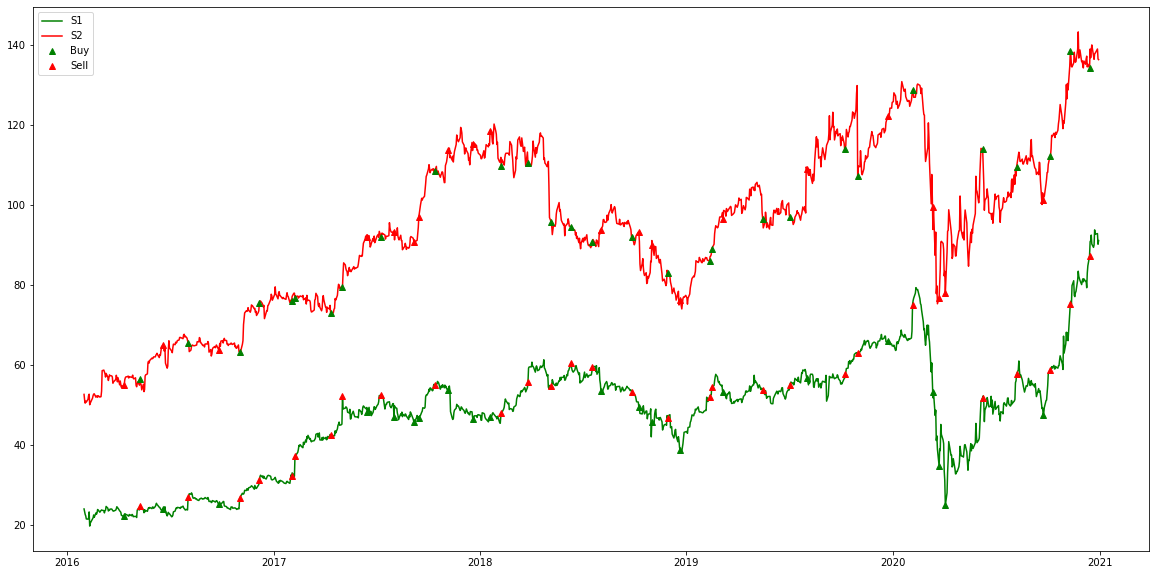

In [66]:
plt.figure(figsize=(20,10))
plt.plot(df_trade.iloc[:,1], label="S1", color='g')
plt.plot(df_trade.iloc[:,0], label="S2", color='r')
plt.plot(s1b, label="Buy", linestyle='None', marker="^", color='g')
plt.plot(s2b, linestyle='None', marker="^", color='g')
plt.plot(s1s, label="Sell", linestyle='None', marker="^", color='r')
plt.plot(s2s, linestyle='None', marker="^", color='r')
plt.legend()